In [32]:
import numpy as np
import xlsxwriter
import time
import os
import codecs
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
from IPython.display import SVG, HTML

_prebin_params_doc = """
    Parameters
    ----------
    y: array-like
        The dependent variable, dim = n*1
    x: array-like
        The independnet variable, dim = n*p
    method: ['quantile', 'bucket']
        The default value is 'quantile'
    binnum: int
        binnum = 20 (default)
    groupnum: int
        groupnum = 4 (default)
    """
_prebin_Result_docs = """
    role: array
        Variables'roles: 1 is selected & 0 is out
    """ 
# Interactive Grouping
class prebin(object):
    __doc__="""
    The Prebin Process
    %(Params_doc)s
    %(Result_doc)s
    Notes
    ----
    """%{"Params_doc":_prebin_params_doc,
         "Result_doc":_prebin_Result_docs}
    
    def __init__(self,data,xname,yname,**kwargs):
        self.data  = data
        self.yname = yname
        self.xname = xname
        self.xvalue = data[xname]
        self.yvalue = data[yname]
        self.binnum = 20
        
        if 'binnum' in kwargs.keys():
            self.binnum = kwargs['binnum']
        self.method = 'quantile'
        if 'method' in kwargs.keys():
            self.method = kwargs['method']
    def binning(self):       
        string_tag = 0
        # **** Split raw_data into nandata and nonandata ****
        if "missing" in list(self.xvalue):
            nanlist = self.xvalue[self.xvalue == "missing"].index
            nandata = self.data[self.xvalue == "missing"]
            nonandata = self.data.drop(nanlist)
            try:
                nonandata[self.xname] = map(float, nonandata[self.xname])
                #print("try")
                string_tag = 0
            except ValueError:
                print("Please Check Whether "+self.xname + " is String type ?" )
                print("process 'Prebin' will take "+self.xname + " as String type !!!")
                string_tag = 1
                
            nandata[self.xname+"_bin"] = "bin_"+str(100)
            nandata["cut_point"]       = "missing"
        else:
            nandata = pd.DataFrame()
            nonandata = self.data
            try:
                nonandata[self.xname] = map(float, nonandata[self.xname])
                #print("try")
                string_tag = 0
            except ValueError:
                print("Please Check Whether "+self.xname + " is String type ?" )
                print("process 'Prebin' will take "+self.xname + " as String type !!!")
                string_tag = 1

        nonandata[self.xname+'_bin'] = nonandata[self.xname]
        nonandata['cut_point']  = nonandata[self.yname]
        
        if (len(set(nonandata[self.xname][:1000])) >= self.binnum):
            if (self.method == 'quantile'):
                bincut = stats.mstats.mquantiles(nonandata[self.xname], prob=np.arange(0,1,1./self.binnum))
                #print(bincut)
            elif (self.method == 'bucket'):
                minvalue = min(nonandata[self.xname])
                maxvalue = max(nonandata[self.xname])
                bincut = np.arange(minvalue, maxvalue, 1.*(maxvalue-minvalue)/self.binnum)
            else:
                print("Error Message: Wrong Prebin mehtod ! Use: 'quantile' or 'bucket' ...")
                raise SystemExit
            bincut = list(set(bincut))   # remove duplicate
            bincut.sort()            
            for i in np.arange(len(bincut)+1):
                if (i == 1):
                    nonandata[self.xname+'_bin'][nonandata[self.xname] <= bincut[i]] = 'bin_'+str(100+i)
                    nonandata['cut_point'][nonandata[self.xname] <= bincut[i]] = bincut[i]
                elif (i>1 and i<len(bincut)):
                    nonandata[self.xname+'_bin'][(nonandata[self.xname] > bincut[i-1])&(nonandata[self.xname]<=bincut[i])] = 'bin_'+str(100+i) 
                    nonandata['cut_point'][(nonandata[self.xname] > bincut[i-1])&(nonandata[self.xname]<=bincut[i])] = bincut[i]
                elif (i == len(bincut)):
                    nonandata[self.xname+'_bin'][nonandata[self.xname] > bincut[i-1]] = 'bin_'+str(100+i)
                    nonandata["cut_point"][nonandata[self.xname] > bincut[i-1]] = max(nonandata[self.xname])
                
        else:
            bincut = list(set(nonandata[self.xname]))
            bincut.sort()
            for i,v in enumerate(bincut):
                nonandata[self.xname+'_bin'][nonandata[self.xname] == i] = 'bin_'+str(100+i+1)
                nonandata['cut_point'][nonandata[self.xname] == bincut[i]] = v
            
        bincut.sort()
        
        newdata = [nandata, nonandata]
      
        return [newdata, string_tag]

class grouping(object):
    
    def __init__(self, data, yname, xname, i, **kwargs):
        self.yname = yname
        self.xname = xname
        self.cnt   = i
        self.nandata = data[0][0]
        self.data  = data[0][1]
        self.string_tag = data[1]
        self.mingroupsize = 0.05
        if 'mingroupsize' in kwargs.keys():
            self.mingroupsize = kwargs['mingroupsize']
            
    def freq(self):
        Dict     = {}
        freqs    = list()
        sumy     = {"y0":0., "y1":0.}
        var_name = list()
        ylist    = list()
        cut      = list()
        _tmpcut_ = list()
        tmpcut   = list()
        _tmpx_   = list(set(self.data[self.xname]))
        _tmpy_   = list(set(self.data[self.yname]))
        _tmpx_.sort()
        _tmpy_.sort()
        
        for name in _tmpx_:
            for y in _tmpy_:
                var_name.append(name)
                ylist.append(y)
                freqs.append(len(self.data[(self.data[self.xname] == name) & (self.data[self.yname] == y)]))
                cut.append(max(self.data.cut_point[self.data[self.xname] == name]))
            _tmpcut_.append(max(self.data.cut_point[self.data[self.xname] == name]))
            
        for k,v in enumerate(_tmpcut_):
            if (self.string_tag == 0) :
                if k > 0 :
                    tmpcut.append((_tmpcut_[k-1]+_tmpcut_[k])/2.)
            else :
                tmpcut.append(_tmpcut_[k])

        freq_table = pd.DataFrame(np.vstack((ylist,var_name,cut,freqs)).T, columns = [self.yname,self.xname,'Cut','Count'])
        if self.string_tag == 0:
            freq_table[[self.yname,'Cut','Count']] = freq_table[[self.yname,'Cut','Count']].astype(float)
        else:
            freq_table[[self.yname,'Count']] = freq_table[[self.yname,'Count']].astype(float)
            
        Dict = {"cutpoint":_tmpcut_, "binx":_tmpx_, "freqy":sumy, "freqtable":freq_table}
        return Dict
    
    def entropy(self, _tmpdata_, y, cut):
        Dict = {}
        toa  = 1.*sum(y.values())
        y_0  = y["y0"]/toa
        y_1  = y["y1"]/toa 
        x_1  = 1.*sum(_tmpdata_.Count[_tmpdata_.Cut <= cut])
        x_2  = toa - x_1
        x11  = 1.*sum(_tmpdata_.Count[(_tmpdata_.Cut <= cut) & (_tmpdata_[self.yname] == 1)])
        x10  = x_1-x11
        x21  = 1.*sum(_tmpdata_.Count[(_tmpdata_.Cut > cut) & (_tmpdata_[self.yname] == 1)])
        x20  = x_2 - x21
        entS = -y_0*np.log2(y_0) - y_1*np.log2(y_1)
        if x10 == 0:
            entx10 = 0
        else:
            entx10 = (x_1/toa)*(-(x10/x_1)*np.log2(x10/x_1))  
        if x11 == 0:
            entx11 = 0
        else:
            entx11 = (x_1/toa)*(-(x11/x_1)*np.log2(x11/x_1))
        if x20 == 0:
            entx20 = 0
        else :
            entx20 = (x_2/toa)*(-(x20/x_2)*np.log2(x20/x_2))
        if x21 == 0:
            entx21 = 0
        else:
            entx21 = (x_2/toa)*(-(x21/x_2)*np.log2(x21/x_2))  
        entx = entx10 + entx11 + entx20 + entx21
        Dict = {cut:(entS-entx)}
        return Dict
    
    def calsplit(self, predata):
        tmpdict = {}
        initvalue = 0.
        cutvalue = {}
        cutpoint = list(set(predata.Cut))
        freqy = {}
        freqy["y0"] = sum(predata.Count[predata[self.yname] == 0])
        freqy["y1"] = sum(predata.Count[predata[self.yname] == 1])
        cutpoint.sort()
        for i, value in enumerate(cutpoint):
            if i < len(cutpoint)-1:
                _binentropy_ = self.entropy(predata, freqy, value)
                if initvalue <= _binentropy_.values()[0]:
                    cutvalue = _binentropy_
                    initvalue = _binentropy_.values()[0]
                tmpdict[i] = _binentropy_
        return cutvalue.keys()[0]
    
    def split(self):
        bestgroup = {}
        cutlist   = list()
        predata   = self.freq()
        freqtable = predata['freqtable']
        total = sum(freqtable.Count)
        minsize = round(total*self.mingroupsize, 0)
        tmpdict0 = self.calsplit(freqtable)
        left0 = sum(freqtable.Count[freqtable.Cut <= tmpdict0])
        right0 = total - left0

        if (left0 < minsize) or (right0 < minsize):
            print "ErrorMessage: mingroupsize is not satisfied!"
            raise SystemExit
        else :
            leftdata0  = freqtable[freqtable.Cut <= tmpdict0]
            leftdata0.index = np.arange(len(leftdata0))
            rightdata0 = freqtable[freqtable.Cut > tmpdict0]
            rightdata0.index = np.arange(len(rightdata0))
            cutlist.append(tmpdict0)

            if (left0 >= 2*minsize) & (len(leftdata0) > 2):
                tmpdict1 = self.calsplit(leftdata0)
                left1  = sum(leftdata0.Count[leftdata0.Cut <= tmpdict1])
                right1 = left0 - left1
                if (left1 >= minsize) & (right1 >= minsize):
                    cutlist.insert(0, tmpdict1)
                    
            if (right0 >= 2*minsize) & (len(rightdata0) > 2):
                tmpdict2 = self.calsplit(rightdata0)
                left2  = sum(rightdata0.Count[rightdata0.Cut <= tmpdict2])
                right2 = right0 - left2

                if (left2 >= minsize) & (right2 >= minsize):
                    cutlist.append(tmpdict2)
        cutlist.sort()
        print (cutlist)
        return [cutlist, freqtable]
    
    def calwoe(self):

        ############  Calculate WOE ###############
        woetable = pd.DataFrame()
        groupname = list()
        groupvalue = list()
        Count  = list()
        Eventcnt = list()
        Noeventcnt = list()
        woevalues = list()
        eventcnt = list()
        noeventcnt = list()
        total = list()
        tmpiv = 0.
        lastvalue = 0.
        sql = ""
        sqlfile.writelines("")
        
        if self.string_tag == 0:
            splitinfo = self.split()
            cutlist   = splitinfo[0]
            groupdata = splitinfo[1]
            totalevent = 1.*sum(groupdata.Count[groupdata[self.yname] == 1])
            totalnoevent = 1.*sum(groupdata.Count[groupdata[self.yname] == 0])
            
            for i, value in enumerate(cutlist):
                groupname.append(i+1)
                Count = sum(groupdata.Count[groupdata.Cut <= value])
                if i == 0 :
                    groupvalue.append(self.xname[:-4] +" <= " +str(value))
                    if self.cnt == 0:
                        sql = "  case when "+ self.xname[:-4] +" <= " +str(value)
                    else :
                        sql = " ,case when "+ self.xname[:-4] +" <= " +str(value)
                    _tmpevent   = sum(groupdata.Count[(groupdata.Cut <= value) & (groupdata[self.yname] == 1)])
                    _tmpnoevent = sum(groupdata.Count[(groupdata.Cut <= value) & (groupdata[self.yname] == 0)])
                else :
                    groupvalue.append("( "+ str(lastvalue)+ " < " + self.xname[:-4] + " <= " +str(value) + "]" )
                    sql = "       when "+self.xname[:-4]+" > "+str(lastvalue)+" and "+self.xname[:-4]+" <= "+str(value)
                    _tmpevent   = sum(groupdata.Count[(groupdata.Cut <= value) & (groupdata[self.yname] == 1) & (groupdata.Cut > cutlist[i-1])])
                    _tmpnoevent = sum(groupdata.Count[(groupdata.Cut <= value) & (groupdata[self.yname] == 0) & (groupdata.Cut > cutlist[i-1])])
                
                lastvalue = value
                
                _tmpwoevalue = np.log((_tmpevent/totalevent)/(_tmpnoevent/totalnoevent))
                tmpiv = tmpiv + (_tmpevent/totalevent - _tmpnoevent/totalnoevent)*_tmpwoevalue
                Eventcnt.append(_tmpevent)
                Noeventcnt.append(_tmpnoevent)
                woevalues.append(_tmpwoevalue)
                sql = sql+" then " + str(_tmpwoevalue)
                
                sqlfile.writelines(sql+"\n")
            
            #***** i = len(cutlist) ****
            groupname.append(i+2)
            Count = (totalevent + totalnoevent)
            groupvalue.append(self.xname[:-4] +" > " + str(value))
            sql = "       when "+self.xname[:-4] +" > " + str(value)
            _tmpevent   = sum(groupdata.Count[(groupdata.Cut > value) & (groupdata[self.yname] == 1)])
            _tmpnoevent = sum(groupdata.Count[(groupdata.Cut > value) & (groupdata[self.yname] == 0)])
            _tmpwoevalue = np.log((_tmpevent/totalevent)/(_tmpnoevent/totalnoevent))
            tmpiv = tmpiv + (_tmpevent/totalevent - _tmpnoevent/totalnoevent)*_tmpwoevalue
            Eventcnt.append(_tmpevent)
            Noeventcnt.append(_tmpnoevent)
            woevalues.append(_tmpwoevalue)
            sql = sql+" then "+str(_tmpwoevalue)
            sqlfile.writelines(sql+"\n")
            
                        
        else :
            strdata   = self.freq()
            groupdata = strdata['freqtable']
            cutlist = list(set(groupdata["Cut"]))
            totalevent = 1.*sum(groupdata.Count[groupdata[self.yname] == 1])
            totalnoevent = 1.*sum(groupdata.Count[groupdata[self.yname] == 0])
            
            for i, value in enumerate(cutlist):
                groupname.append(i+1)
                Count = sum(groupdata.Count[groupdata.Cut == value])
                groupvalue.append(self.xname[:-4] + " = " + str(value))
                if i == 0:
                    if self.cnt == 0:
                        sql = " case when "+ self.xname[:-4] + " = " + str(value)
                    else :
                        sql = " ,case when "+ self.xname[:-4] + " = " + str(value)
                else :
                    sql = "       when "+self.xname[:-4] + " = " + str(value)
                _tmpevent = sum(groupdata.Count[(groupdata.Cut == value) & (groupdata[self.yname] == 1)])
                _tmpnoevent = sum(groupdata.Count[(groupdata.Cut == value) & (groupdata[self.yname] == 0)])
                _tmpwoevalue = np.log((_tmpevent/totalevent)/(_tmpnoevent/totalnoevent))
                tmpiv = tmpiv + (_tmpevent/totalevent - _tmpnoevent/totalnoevent)*_tmpwoevalue
                
                Eventcnt.append(_tmpevent)
                Noeventcnt.append(_tmpnoevent)
                woevalues.append(_tmpwoevalue)
                sql = sql+" then "+str(_tmpwoevalue)
                sqlfile.writelines(sql+"\n")
  
        if len(self.nandata) > 0:
            groupname.append(i+3)
            groupvalue.append("missing")
            Count = len(self.nandata)
            _tmpevent = sum(self.nandata[self.yname])
            _tmpnoevent = Count - _tmpevent
            _tmpwoevalue = np.log((_tmpevent/totalevent)/(_tmpnoevent/totalnoevent))
            tmpiv = tmpiv + (_tmpevent/totalevent - _tmpnoevent/totalnoevent)*_tmpwoevalue
            Eventcnt.append(_tmpevent)
            Noeventcnt.append(_tmpnoevent)
            woevalues.append(_tmpwoevalue)
            sql = "       when "+self.xname[:-4]+" = missing then "+str(_tmpwoevalue)+" end as "+self.xname[:-4]+"_woe"
        else :
            sql = "       else 0.0000 end as "+self.xname[:-4]+"_woe"        
        sqlfile.writelines(sql+"\n")
        woetable["Groups"]  = groupname
        woetable["Cutoff"] = groupvalue
        woetable["Bad"]  = Eventcnt
        woetable["Good"]  = Noeventcnt
        woetable["WOE"]  = woevalues
        
        # **** Print WOE Chart ****
        if tmpiv >= 0.01 :
            plt.figure(self.cnt)
            plt.subplot(1,2,1)
            axi = np.arange(len(groupname))+1.1
            plt.xticks(axi, groupname)
            plt.plot(axi, woevalues, 'bo-')
            plt.grid(True)
            plt.title('WOE')
            plt.ylabel('WOE Value')
            plt.xlabel('Group')
            plt.subplot(1,2,2)
            plt.xticks(axi, groupname)
            bar1 = plt.bar(axi, Noeventcnt, width=0.5,align='center', color='b')
            bar2 = plt.bar(axi, Eventcnt, width=0.5,align='center', color='m')
            plt.legend((bar1[0], bar2[0]), ('noevent','event'))
            plt.grid(True)
            plt.title('Group Distribution')
            plt.ylabel('Count')
            plt.xlabel('Group')
            plt.savefig(self.xname[:-4]+'.png', dpi = 72)
            #plt.show() 
            # export woe_table and chart into xlsx file
            worksheet1  = workbook.add_worksheet(self.xname[:-4])
            worksheet1.write_row(0, 0, woetable, format_title)
            for i in np.arange(len(woetable)):
                worksheet1.write_row(i+1, 0, woetable.values[i], format)
            worksheet1.insert_image('G1', self.xname[:-4]+'.png')     
        return [woetable, tmpiv]

/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

[35.0, 46.0, 62.0]
[22.0, 65.0, 82.579999999999998]
[25410.0, 29000.0, 41000.0]
[28.0, 32.0, 84.0]
[0.0]
Please Check Whether EmpStatus is String type ?
process 'Prebin' will take EmpStatus as String type !!!


/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


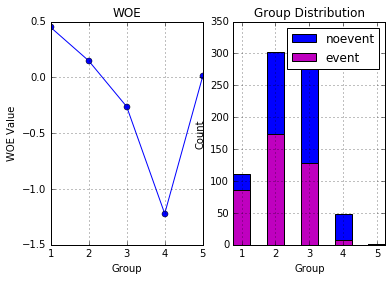

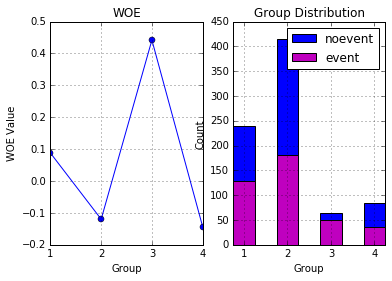

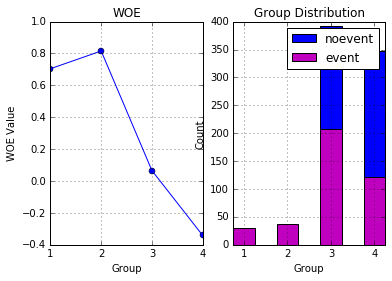

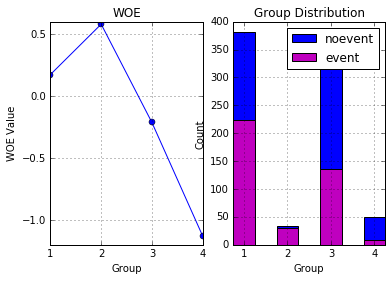

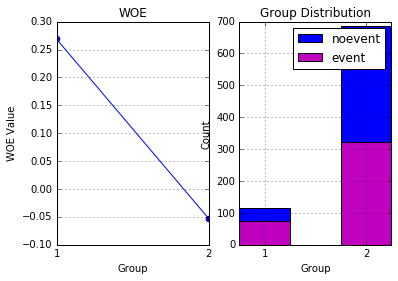

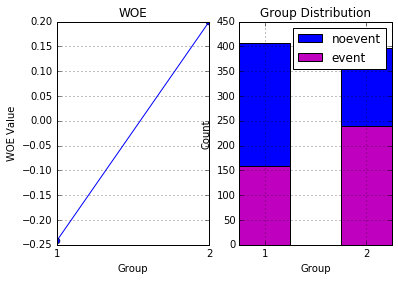

In [2]:
loctime = time.strftime('%Y%m%d%s',time.localtime(time.time()))
workbook    = xlsxwriter.Workbook('WOE_Tables_'+loctime+'.xlsx')

format=workbook.add_format()    #定义format格式对象
format.set_border(1)    #定义format对象单元格边框加粗(1像素)的格式
 
format_title=workbook.add_format()    #定义format_title格式对象
format_title.set_border(2)   #定义format_title对象单元格边框加粗(1像素)的格式
format_title.set_bg_color('#cccccc')   #定义format_title对象单元格背景颜色为
                                       #'#cccccc'的格式
format_title.set_align('center')    #定义format_title对象单元格居中对齐的格式
format_title.set_bold()    #定义format_title对象单元格内容加粗的格式
format_title.set_num_format('00000000')   #定义format_ave对象单元格数字类别显示格式
 
format_ave=workbook.add_format()    #定义format_ave格式对象
format_ave.set_border(1)    #定义format_ave对象单元格边框加粗(1像素)的格式
format_ave.set_num_format('0.00')   #定义format_ave对象单元格数字类别显示格式


xnames = ['CustAge', 'TmAtAddress', 'CustIncome', 'TmWBank', 'OtherCC', "EmpStatus"]
data = pd.read_csv('/home/dzn/Project/d05_scorecard/d02_InteractiveGrouping/data/creditcard.csv')
#IV_table = pd.DataFrame()
IV_list = list()
for i, xname in enumerate(xnames):
    ds = data[['Status', xname]]
    g  = prebin(data,xname,'Status', method='quantile')
    aa = g.binning()
    x_bin = xname+"_bin"
    bbb = grouping(aa,'Status',x_bin,i, mingroupsize = 0.02)
    cvb = bbb.calwoe()
    #print("xname = " + xname)
    #print(cvb)
    #aa[0]
    os.system("rm -rf "+x_bin[:-4]+'.png')   
    IV_list.append(cvb[1])

#IV_table["Variables"] = xnames
#IV_table["IV"] = IV_list

worksheet1  = workbook.add_worksheet("IV")
worksheet1.write_row(0, 0, ["Vars", "IV"], format_title)
worksheet1.write_column(1, 0, xnames, format)
worksheet1.write_column(1, 1, IV_list, format)

workbook.close()

In [10]:
xnames = ['A1', 'A127', 'A86', 'A146']
datafile = '/home/dzn/Project/d05_scorecard/d02_InteractiveGrouping/data/ab.csv'
dataname = datafile.split("/")[-1].split(".")[0]
datapath = datafile.split(dataname)[:-1][0]
data = pd.read_csv(datafile)

/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main_

[20.0, 30.0, 59.0]
[3.0, 7.0, 10.0]
[2000.0, 17000.0, 24000.0]

/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel-4.2.1-py2.7.egg/ipykernel/__main__.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[1.0, 2.0]


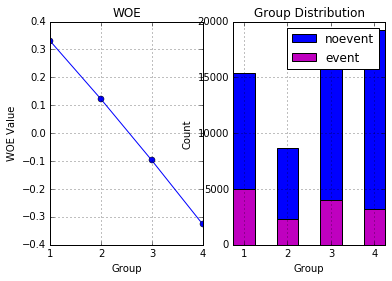

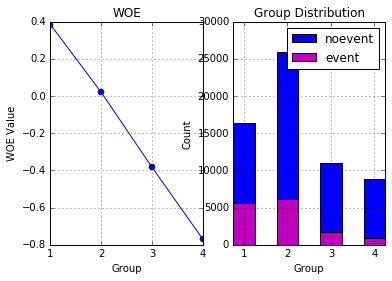

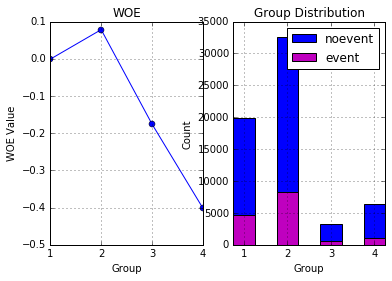

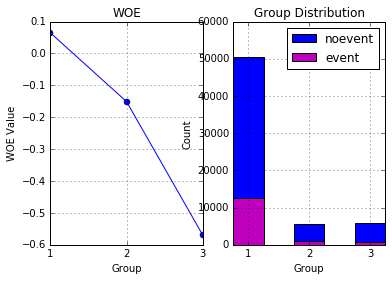

In [33]:
loctime = time.strftime('%Y%m%d%s',time.localtime(time.time()))
os.system("rm -rf "+datapath+dataname)
os.system("mkdir "+datapath+dataname)
sqlpath = datapath+dataname+"/grouping_info.sql"
woepath = datapath+dataname+"/woe_info.xlsx"

sqlfile = codecs.open(sqlpath, 'w')

workbook = xlsxwriter.Workbook(woepath)

format=workbook.add_format()    #定义format格式对象
format.set_border(1)    #定义format对象单元格边框加粗(1像素)的格式
 
format_title=workbook.add_format()    #定义format_title格式对象
format_title.set_border(2)   #定义format_title对象单元格边框加粗(1像素)的格式
format_title.set_bg_color('#cccccc')   #定义format_title对象单元格背景颜色为
                                       #'#cccccc'的格式
format_title.set_align('center')    #定义format_title对象单元格居中对齐的格式
format_title.set_bold()    #定义format_title对象单元格内容加粗的格式
format_title.set_num_format('00000000')   #定义format_ave对象单元格数字类别显示格式
 
format_ave=workbook.add_format()    #定义format_ave格式对象
format_ave.set_border(1)    #定义format_ave对象单元格边框加粗(1像素)的格式
format_ave.set_num_format('0.00')   #定义format_ave对象单元格数字类别显示格式

IV_list = list()
for i, xname in enumerate(xnames):
    ds = data[['y', xname]]
    g  = prebin(data,xname,'y', method='quantile')
    aa = g.binning()
    x_bin = xname+"_bin"
    bbb = grouping(aa, 'y', x_bin, i, mingroupsize = 0.05)
    cvb = bbb.calwoe()
    #print("xname = " + xname)
    #print(cvb)
    #aa[0]  
    IV_list.append(cvb[1])

worksheet1  = workbook.add_worksheet("IV")
worksheet1.write_row(0, 0, ["Vars", "IV"], format_title)
worksheet1.write_column(1, 0, xnames, format)
worksheet1.write_column(1, 1, IV_list, format)

sqlfile.close()
workbook.close()